In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import random
import matplotlib.pyplot
import matplotlib.pyplot as plt
from tqdm import tqdm

# Genetic Algorithm

In this Jupyter notebook we will explore a very simple GA. Lets start by loading the breast cancer dataset from the UCI repo (https://archive.ics.uci.edu/ml/datasets/breast+cancer)

In [2]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

cancer=load_breast_cancer()
df = pd.DataFrame(cancer['data'],columns=cancer['feature_names'])
label=cancer["target"]

Lets split this data into training and testing.

In [3]:
#splitting the model into training and testing set
X_train, X_test, y_train, y_test = train_test_split(df, label, test_size=0.30, random_state=101)

Let's train a regression model. This is a "machine learing/statistics/..." mathematical model that takes a number of inputs and predicts a set of outputs.

In [4]:
from warnings import filterwarnings
filterwarnings('ignore')

logmodel = LogisticRegression() # build the logistic regression machine
logmodel.fit(X_train,y_train) # the training function
predictions = logmodel.predict(X_test) # run on the test data
print("Accuracy = "+ str(accuracy_score(y_test,predictions))) # what is the accuracy?

Accuracy = 0.9239766081871345


**NOW, what if we use a genetic algorithm for feature selection?** 

That is, maybe all the features are not to our benefit. What if instead we use a subset? Well, how can we find this subset? Why not use a GA? Well, its an example for this class, not arguing here that a GA is the best solution to this particular problem. Trying to keep our example small enough for you to follow!

There are MANY ways we can go about this, for day one, howabout a chromosome is a {USE, NOT USE} per feature. 

First, lets initilize the population.

In [5]:
def initilization_of_population(size, n_feat):
    population = []
    for i in range(size): # do for each chromo
        chromosome = np.ones(n_feat,dtype=bool) # include all features to start
        chromosome[:int(0.3*n_feat)]=False # now, turn off 30% of our features (yes, you could have passed this as an argument!!!)
        np.random.shuffle(chromosome) # randomly shuffle who is on/off
        population.append(chromosome) # add to our population
    return population

Now, lets define our fitness function. 

For each chromosome, we need to train with respect to its feature subset then evaluate it. Yes, that requires a bit of computation.

The function returns a sorted (best to worst) set of scores and chromosomes.

In [6]:
def fitness_score(population):
    scores = []
    for chromosome in population: # lets walk through each chromo
        logmodel.fit(X_train.iloc[:,chromosome],y_train) # use the features we selected to train a model
        predictions = logmodel.predict(X_test.iloc[:,chromosome]) # eval that model
        scores.append(accuracy_score(y_test,predictions)) # store that score
    scores, pop = np.array(scores), np.array(population.copy()) 
    inds = np.argsort(scores) # returns the indices that would sort an array
    scores = list(scores[inds][::-1]) # make it a list data structure
    pop = list(pop[inds,:][::-1]) # make it a list data structure
    return scores, pop

Now, perform selection, using roulette wheel. In particular, lets say there are two parents to make a child. I will generate twice the number of chromosomes.

In [7]:
def selection(scores,pop_after_fit):
    population_nextgen = []
    # first two entries will be used for elitism (i.e., keep that best solution from generation to next)
    population_nextgen.append(pop_after_fit[0].copy())
    population_nextgen.append(pop_after_fit[0].copy())
    # now, select the other parents
    max_val = np.sum(scores)
    for i in range(1,len(scores)):
        for k in range(2): # 2 parents 
            pick = random.uniform(0, max_val)
            current = 0
            for j in range(len(scores)): # accum
                current += scores[j]
                if current > pick: # our exit criteria based on the probability above
                    break 
            population_nextgen.append(pop_after_fit[j].copy()) 
    return population_nextgen

Crossover here takes two parents and makes a child

In [8]:
def crossover(pop_after_sel,sz):
    # how many features?
    n_feat = len(pop_after_sel[0])
    # next generation
    population_nextgen = [] 
    # first, elitism
    population_nextgen.append(pop_after_sel[0].copy())
    # now, handle the rest
    for i in range(1,sz):
        # make our child (parent 1)
        child = pop_after_sel[2*i+0].copy()
        # get the second parent
        parent2 = pop_after_sel[2*i+1].copy()
        # two point crossover
        first_cross_point = random.randint(0,n_feat)
        second_cross_point = random.randint(0,n_feat)
        # did we get the same point? have to deal with that
        if( first_cross_point == second_cross_point ):
            first_cross_point = 0
            second_cross_point = n_feat
        # are our swap indices not in order? have to deal with that
        if( first_cross_point > second_cross_point ):
            swaper = first_cross_point
            first_cross_point = second_cross_point
            second_cross_point = swaper
        # swap 
        child[first_cross_point:second_cross_point] = parent2[first_cross_point:second_cross_point]
        population_nextgen.append(child) 
    return population_nextgen

Mutation time!!!

Like all the operations above, there are many ways to implement them (which we talk about in the class). Now, with respect to mutation, here we go through each chromosome and mutate using the probability that the user specified, per feature. 

In [9]:
def mutation(pop_after_cross,mutation_rate,sz):
    population_nextgen = []
    population_nextgen.append(pop_after_cross[0].copy())
    for i in range(1,sz): # go through each individual
        chromosome = pop_after_cross[i].copy()
        for j in range(len(chromosome)): # go through each feature
            if random.random() < mutation_rate:
                chromosome[j]= not chromosome[j] # this is the mutation
        population_nextgen.append(chromosome.copy())
    return population_nextgen

Our main function/loop

In [10]:
#from tqdm import tqdm_notebook as tqdm
from tqdm.notebook import tqdm

def generations(sz,n_feat,mutation_rate,n_gen,X_train,
                                   X_test, y_train, y_test):
    # size = how many chromo's
    # n_feat = how many features
    # mutation rate, [0,1]
    # number of generations to run
    # the rest is our training and testing data and labels
    best_chromo = []
    best_score = []
    population_nextgen = initilization_of_population(sz,n_feat)
    stats_min = np.zeros(n_gen)
    stats_avg = np.zeros(n_gen)
    stats_max = np.zeros(n_gen)
    for i in tqdm(range(n_gen)):
        # evaluate our chromos
        scores, pop_after_fit = fitness_score(population_nextgen)
        # keep track of best chromo and its score (what we return the end of the day)
        best_chromo.append(pop_after_fit[0].copy())
        best_score.append(scores[0].copy())        
        # record some stats
        stats_min[i] = np.min(scores)
        stats_max[i] = np.amax(scores)
        stats_avg[i] = np.mean(scores)
        # do our GA
        pop_sel = selection(scores,pop_after_fit)
        pop_after_cross = crossover(pop_sel,sz)
        population_nextgen = mutation(pop_after_cross,mutation_rate,sz)
    return best_chromo,best_score,stats_min,stats_avg,stats_max

Run the algorithm and plot some statistics per generation

  0%|          | 0/100 [00:00<?, ?it/s]

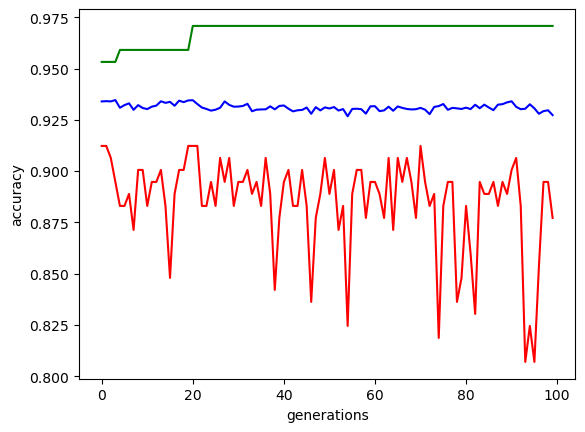

In [11]:
s = 100 # number of individuals
feat = 30 # number of features in our problem
ngen = 100 # number of generations
chromo,score,stats_min,stats_avg,stats_max=generations(sz=s,n_feat=feat,mutation_rate=0.10,n_gen=ngen,X_train=X_train,X_test=X_test,y_train=y_train,y_test=y_test)

# plot the statistics
plt.plot(stats_min,'r')
plt.plot(stats_avg,'b')
plt.plot(stats_max,'g')
plt.ylabel('accuracy')
plt.xlabel('generations')
plt.show()

# Q&A

Things for you to consider

 * We used elitism, was the best score (strictly?) monotonicly increasing? Explain.
 * Change crossover and/or mutation to a different operator
 * Do you want little or a lot of variance in your (min, average, max) statistics (whats a healthy profile)?
 * When should you terminate? 
 * Plug in a different optimization problem from https://en.wikipedia.org/wiki/Test_functions_for_optimization